In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train and X_test are your data

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

In [41]:
# Load your dataset
data_raw = pd.read_csv('drive/MyDrive/rugpull_predictor/merged_pool_data2.csv', index_col='pool_id')

# This selects all columns except 'Label' as features
X = data_raw.drop('rugpull', axis=1)
for column in X.columns:
  if 'tick' in column or 'logindex' in column or 'weth' in column:
    X = X.drop(column, axis=1)
y = data_raw['rugpull']  # Assuming 'Label' is the column with the rugpull indicator

# Split the dataset into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Choose the scaler you want to use
scaler = StandardScaler()
# scaler = RobustScaler()

# Fit on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert scaled arrays back to DataFrame for compatibility with plotting functions
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

In [43]:
import os

# Define the path for the PDF
pdf_path = 'model_output.pdf'

# Check if the directory exists, if not, create it
if not os.path.exists('/content/output/'):
    os.makedirs('/content/output/')

pdf_full_path = os.path.join('/content/output/', pdf_path)

Training Logistic Regression...
Evaluating Logistic Regression...
937 0
Accuracy of Logistic Regression: 85.06%
              precision    recall  f1-score   support

       False       0.85      1.00      0.92       797
        True       0.00      0.00      0.00       140

    accuracy                           0.85       937
   macro avg       0.43      0.50      0.46       937
weighted avg       0.72      0.85      0.78       937

------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature Importances for Logistic Regression:
Training Random Forest...
Evaluating Random Forest...
840 97
Accuracy of Random Forest: 91.36%
              precision    recall  f1-score   support

       False       0.93      0.98      0.95       797
        True       0.80      0.56      0.66       140

    accuracy                           0.91       937
   macro avg       0.87      0.77      0.80       937
weighted avg       0.91      0.91      0.91       937

------------------------------------------------------------
Feature Importances for Random Forest:
Training XGBoost...
Evaluating XGBoost...
823 114
Accuracy of XGBoost: 92.32%
              precision    recall  f1-score   support

       False       0.94      0.97      0.96       797
        True       0.80      0.65      0.72       140

    accuracy                           0.92       937
   macro avg       0.87      0.81      0.84       937
weighted avg       0.92      0.92      0.92       937

----------------------------

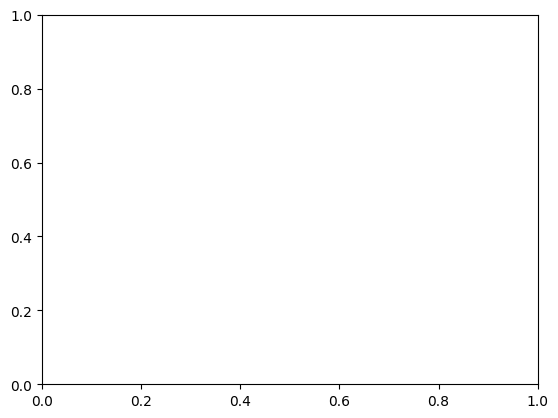

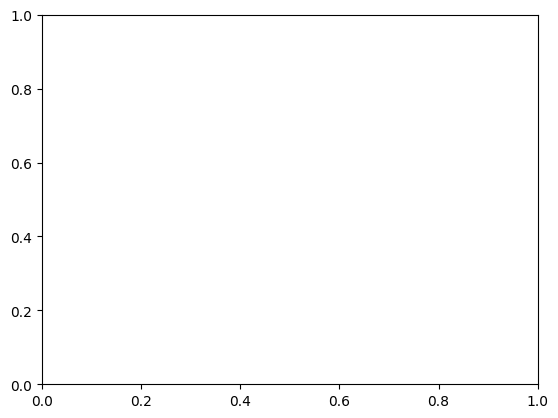

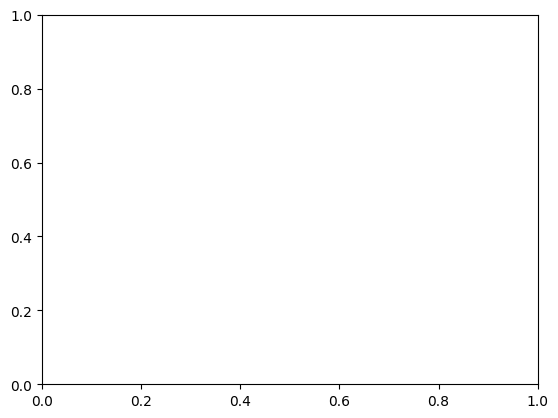

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Define a dictionary with classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    # "Support Vector Machine": SVC(kernel='linear'),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
}

def plot_coefficients(classifier, feature_names, classifier_name):
    if hasattr(classifier, 'coef_'):
        # Get the coefficients
        coefs = classifier.coef_.flatten()
        # Sort the coefficients
        sorted_coefs = np.argsort(coefs)

        # Plot the coefficients
        plt.figure(figsize=(10, 6))
        plt.barh(np.arange(len(coefs)), coefs[sorted_coefs], align='center')
        plt.yticks(np.arange(len(coefs)), feature_names[sorted_coefs])
        plt.xlabel('Coefficient Value')
        plt.title(f'Feature Importance for {classifier_name}')
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')  # Save the figure
        plt.close()  # Close the figure

# Function to plot feature importances
def plot_feature_importances(classifier, X_data, classifier_name):
    # Retrieve feature importances and make sure they're in the same order
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]

    # # Summarize feature importances
    # for f in range(X_data.shape[1]):
    #     print("%d. Feature %s (%f)" % (f + 1, X_data.columns[indices[f]], importances[indices[f]]))

    # Plot feature importances
    plt.figure()
    plt.title(f"Feature Importances in {classifier_name}")
    plt.bar(range(X_data.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_data.shape[1]), X_data.columns[indices], rotation=90)
    plt.xlim([-1, X_data.shape[1]])
    pdf.savefig(bbox_inches='tight')  # Save the figure
    plt.close()  # Close the figure

# Open a PDF document
with PdfPages(pdf_full_path) as pdf:
    # Iterate over classifiers to train and evaluate them and print feature importances
    for name, clf in classifiers.items():
        fig, ax = plt.subplots()  # Create a figure for the text output

        print(f"Training {name}...")
        clf.fit(X_train, y_train)  # Train the classifier

        print(f"Evaluating {name}...")
        y_pred = clf.predict(X_test)  # Make predictions

        print(np.array([y_pred == False]).sum(), np.array([y_pred == True]).sum())
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f"Accuracy of {name}: %.2f%%" % (accuracy * 100.0))
        print(report)
        print("-" * 60)

        # Write the text output to the PDF
        # Create a figure for the text output
        fig, ax = plt.subplots()
        ax.axis('off')
        text_output = f"Training {name}...\nAccuracy of {name}: {accuracy * 100.0:.2f}%\n\nClassification Report:\n{report}"
        ax.text(0, 1, text_output, va='top', ha='left')
        pdf.savefig(fig, bbox_inches='tight')  # Save the text output figure
        plt.close(fig)

        print(f"Feature Importances for {name}:")
        if hasattr(clf, 'feature_importances_'):
            plot_feature_importances(clf, X_train, name)
        elif isinstance(clf, SVC) and clf.kernel == 'linear':
            plot_coefficients(clf, X_train.columns, name)
        elif isinstance(clf, LogisticRegression):
            plot_coefficients(clf, X_train.columns, name)
